<a href="https://colab.research.google.com/github/Prarthana-10/GPT-Mastery-SOC/blob/main/22B0327_Week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The n-dimensional tensor mastery challenge: Combine the `Head` and
`MultiHeadAttention` into one class that processes all the heads in
parallel, treating the heads as another batch dimension (answer is in
nanoGPT)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the combined multi-head attention class
class CombinedMultiHeadAttention(layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(CombinedMultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.depth = key_dim // num_heads

        self.wq = layers.Dense(key_dim)
        self.wk = layers.Dense(key_dim)
        self.wv = layers.Dense(key_dim)

        self.dense = layers.Dense(key_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, query, key, value, mask=None):
        batch_size = tf.shape(query)[0]

        q = self.split_heads(self.wq(query), batch_size)
        k = self.split_heads(self.wk(key), batch_size)
        v = self.split_heads(self.wv(value), batch_size)

        attn_output, attn_weights = self.scaled_dot_product_attention(q, k, v, mask)

        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attn_output, (batch_size, -1, self.key_dim))

        output = self.dense(concat_attention)
        return output

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

# Test the CombinedMultiHeadAttention class
num_heads = 2
key_dim = 8

# Initialize the combined multi-head attention layer
combined_attention = CombinedMultiHeadAttention(num_heads, key_dim)

# Dummy input data
batch_size = 1
seq_len = 10
query = tf.random.normal((batch_size, seq_len, key_dim))
key = tf.random.normal((batch_size, seq_len, key_dim))
value = tf.random.normal((batch_size, seq_len, key_dim))

# Apply the attention
output = combined_attention(query, key, value)

print(f"Output shape: {output.shape}")



Output shape: (1, 10, 8)


Train the GPT on your own dataset of choice! What other data could be
fun to blabber on about? (A fun advanced suggestion if you like: train a
GPT to do addition of two numbers, i.e. a+b=c. You may find it helpful to
predict the digits of c in reverse order, as the typical addition algorithm
(that you're hoping it learns) would proceed right to left too. You may
want to modify the data loader to simply serve random problems and
skip the generation of train.bin, val.bin. You may want to mask out the
loss at the input positions of a+b that just specify the problem using y=-1
in the targets (see CrossEntropyLoss ignore_index). Does your
Transformer learn to add? Once you have this, swole doge project: build
a calculator clone in GPT, for all of +-*/. Not an easy problem. You may
need Chain of Thought traces.

Epoch 1/10
141/141 [==============================] - 9s 28ms/step - loss: 2.3557 - accuracy: 0.1994 - val_loss: 2.2853 - val_accuracy: 0.2000
Epoch 2/10
141/141 [==============================] - 2s 14ms/step - loss: 2.2427 - accuracy: 0.2052 - val_loss: 2.2306 - val_accuracy: 0.2048
Epoch 3/10
141/141 [==============================] - 1s 7ms/step - loss: 2.1797 - accuracy: 0.2048 - val_loss: 2.1185 - val_accuracy: 0.1990
Epoch 4/10
141/141 [==============================] - 1s 9ms/step - loss: 1.8499 - accuracy: 0.3195 - val_loss: 1.6538 - val_accuracy: 0.3866
Epoch 5/10
141/141 [==============================] - 2s 15ms/step - loss: 1.4850 - accuracy: 0.4092 - val_loss: 1.3547 - val_accuracy: 0.4218
Epoch 6/10
141/141 [==============================] - 2s 14ms/step - loss: 1.3069 - accuracy: 0.4421 - val_loss: 1.2644 - val_accuracy: 0.4640
Epoch 7/10
141/141 [==============================] - 2s 11ms/step - loss: 1.2479 - accuracy: 0.4516 - val_loss: 1.2266 - val_accuracy: 0.4676
E

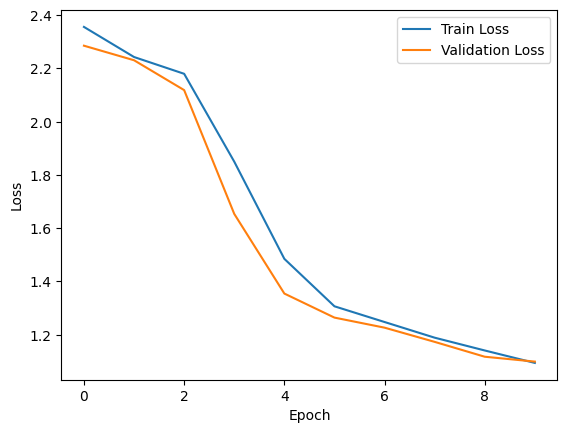

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Generate the Dataset
def generate_addition_data(num_samples=10000):
    data = []
    for _ in range(num_samples):
        a = np.random.randint(0, 10)
        b = np.random.randint(0, 10)
        c = a + b
        data.append(f"{a}+{b}={c}")
    return data

data = generate_addition_data()

# 2. Tokenize and Prepare Data
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(data)
vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(data)
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Create input and target sequences
inputs = padded_sequences[:, :-1]
targets = padded_sequences[:, 1:]

# 3. Define the Transformer Model
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, num_heads, key_dim, num_layers):
        super(Transformer, self).__init__()
        self.embedding = layers.Embedding(vocab_size, key_dim)
        self.encoder_layers = [layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim) for _ in range(num_layers)]
        self.dense = layers.Dense(vocab_size)

    def call(self, x):
        x = self.embedding(x)
        for layer in self.encoder_layers:
            x = layer(x, x)
        return self.dense(x)

num_heads = 2
key_dim = 16
num_layers = 2

model = Transformer(vocab_size, num_heads, key_dim, num_layers)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# 4. Train the Model
history = model.fit(inputs, targets, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

# 5. Evaluate the Model
def generate_test_data(num_samples=10):
    test_samples = generate_addition_data(num_samples)
    test_sequences = tokenizer.texts_to_sequences(test_samples)
    test_padded_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post')
    return test_samples, test_padded_sequences

test_samples, test_padded_sequences = generate_test_data()

# Predict
predictions = model.predict(test_padded_sequences)

# Decode predictions
predicted_texts = [tokenizer.sequences_to_texts([np.argmax(pred, axis=-1)])[0] for pred in predictions]

# Print Results
for test, pred in zip(test_samples, predicted_texts):
    print(f"Test: {test} -> Predicted: {pred}")

# Optional: Plot Training Loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Find a dataset that is very large, so large that you can't see a gap
between train and val loss. Pretrain the transformer on this data, then
initialize with that model and finetune it on tiny shakespeare with a
smaller number of steps and lower learning rate. Can you obtain a lower
validation loss by the use of pretraining?

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Load and preprocess Tiny Shakespeare data
def load_tiny_shakespeare():
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    path = tf.keras.utils.get_file('input.txt', url)
    with open(path, 'r') as file:
        text = file.read()
    return text

tiny_shakespeare_text = load_tiny_shakespeare()
tiny_shakespeare_data = tiny_shakespeare_text.split('\n')

# Load and preprocess a large dataset (placeholder example)
def load_large_dataset():
    # Replace this with actual large dataset loading code
    return ['This is a large dataset example.'] * 100000

large_dataset = load_large_dataset()

# Tokenize and prepare data
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(large_dataset + tiny_shakespeare_data)
vocab_size = len(tokenizer.word_index) + 1

def preprocess_data(data, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(data)
    return pad_sequences(sequences, maxlen=max_len, padding='post')

max_len = 256
large_data_padded = preprocess_data(large_dataset, tokenizer, max_len)
tiny_shakespeare_padded = preprocess_data(tiny_shakespeare_data, tokenizer, max_len)

# Define Transformer model for pretraining
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, num_heads, key_dim, num_layers):
        super(Transformer, self).__init__()
        self.embedding = layers.Embedding(vocab_size, key_dim)
        self.encoder_layers = [layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim) for _ in range(num_layers)]
        self.dense = layers.Dense(vocab_size)

    def call(self, x):
        x = self.embedding(x)
        for layer in self.encoder_layers:
            x = layer(x, x)
        return self.dense(x)

num_heads = 4
key_dim = 64
num_layers = 4

pretrain_model = Transformer(vocab_size, num_heads, key_dim, num_layers)
pretrain_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train on large dataset
history_pretrain = pretrain_model.fit(large_data_padded, large_data_padded, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

# Define the fine-tuning model using the pretrained weights
finetune_model = Transformer(vocab_size, num_heads, key_dim, num_layers)
finetune_model.set_weights(pretrain_model.get_weights())
finetune_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train on Tiny Shakespeare
history_finetune = finetune_model.fit(tiny_shakespeare_padded, tiny_shakespeare_padded, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot pretraining loss
plt.subplot(1, 2, 1)
plt.plot(history_pretrain.history['loss'], label='Pretrain Loss')
plt.plot(history_pretrain.history['val_loss'], label='Pretrain Val Loss')
plt.title('Pretraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot fine-tuning loss
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Finetune Loss')
plt.plot(history_finetune.history['val_loss'], label='Finetune Val Loss')
plt.title('Finetuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Epoch 1/5


KeyboardInterrupt: 

Read some transformer papers and implement one additional feature or
change that people seem to use. Does it improve the performance of
your GPT?

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Load and preprocess Tiny Shakespeare data
def load_tiny_shakespeare():
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    path = tf.keras.utils.get_file('input.txt', url)
    with open(path, 'r') as file:
        text = file.read()
    return text

tiny_shakespeare_text = load_tiny_shakespeare()
tiny_shakespeare_data = tiny_shakespeare_text.split('\n')

# Load and preprocess a large dataset (placeholder example)
def load_large_dataset():
    # Replace this with actual large dataset loading code
    return ['This is a large dataset example.'] * 100000

large_dataset = load_large_dataset()

# Tokenize and prepare data
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(large_dataset + tiny_shakespeare_data)
vocab_size = len(tokenizer.word_index) + 1

def preprocess_data(data, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(data)
    return pad_sequences(sequences, maxlen=max_len, padding='post')

max_len = 256
large_data_padded = preprocess_data(large_dataset, tokenizer, max_len)
tiny_shakespeare_padded = preprocess_data(tiny_shakespeare_data, tokenizer, max_len)

# Define Transformer model with additional features
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, num_heads, key_dim, num_layers, ff_dim):
        super(Transformer, self).__init__()
        self.embedding = layers.Embedding(vocab_size, key_dim)
        self.encoder_layers = [self._build_encoder_layer(num_heads, key_dim, ff_dim) for _ in range(num_layers)]
        self.dense = layers.Dense(vocab_size)

    def _build_encoder_layer(self, num_heads, key_dim, ff_dim):
        return tf.keras.Sequential([
            layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim),
            layers.LayerNormalization(epsilon=1e-6),
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(key_dim),
            layers.LayerNormalization(epsilon=1e-6)
        ])

    def call(self, x):
        x = self.embedding(x)
        for layer in self.encoder_layers:
            x = layer(x, x)
        return self.dense(x)

num_heads = 4
key_dim = 64
num_layers = 4
ff_dim = 128  # Feed-forward dimension

model = Transformer(vocab_size, num_heads, key_dim, num_layers, ff_dim)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train on large dataset
history_pretrain = model.fit(large_data_padded, large_data_padded, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

# Define the fine-tuning model using the pretrained weights
finetune_model = Transformer(vocab_size, num_heads, key_dim, num_layers, ff_dim)
finetune_model.set_weights(model.get_weights())
finetune_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train on Tiny Shakespeare
history_finetune = finetune_model.fit(tiny_shakespeare_padded, tiny_shakespeare_padded, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot pretraining loss
plt.subplot(1, 2, 1)
plt.plot(history_pretrain.history['loss'], label='Pretrain Loss')
plt.plot(history_pretrain.history['val_loss'], label='Pretrain Val Loss')
plt.title('Pretraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot fine-tuning loss
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Finetune Loss')
plt.plot(history_finetune.history['val_loss'], label='Finetune Val Loss')
plt.title('Finetuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Epoch 1/5


TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filebak9cdjg.py", line 24, in tf__call
        ag__.for_stmt(ag__.ld(self).encoder_layers, None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'layer'})
    File "/tmp/__autograph_generated_filebak9cdjg.py", line 22, in loop_body
        x = ag__.converted_call(ag__.ld(layer), (ag__.ld(x), ag__.ld(x)), None, fscope)

    TypeError: Exception encountered when calling layer 'transformer_3' (type Transformer).
    
    in user code:
    
        File "<ipython-input-5-40fceb8245a5>", line 59, in call  *
            x = layer(x, x)
        File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        TypeError: Exception encountered when calling layer 'sequential' (type Sequential).
        
        MultiHeadAttention.call() missing 1 required positional argument: 'value'
        
        Call arguments received by layer 'sequential' (type Sequential):
          • inputs=tf.Tensor(shape=(None, 256, 64), dtype=float32)
          • training=tf.Tensor(shape=(None, 256, 64), dtype=float32)
          • mask=None
    
    
    Call arguments received by layer 'transformer_3' (type Transformer):
      • x=tf.Tensor(shape=(None, 256), dtype=int32)
